In [27]:
import os
from pydap.client import open_url
import xarray as xr
import datetime
from datetime import timedelta, date
import netCDF4 as nc
from netCDF4 import Dataset
import os
import sys
import json
import pickle

sys.path.append(os.path.abspath(".."))
from utils.degree_day_equations import *
from utils.net_cdf_functions import *
from utils.processing_functions import *

import gc

# from utils.visualization_functions import *

import pandas as pd

# from visualization_functions import *
import numpy as np

data_path = "../data/"

In [28]:
from dask import delayed
import time


def fflies_model_1(data, start, threshold):
    # Ensure data is an xarray DataArray
    if isinstance(data, np.ndarray):
        data = xr.DataArray(data)

    # Initialize cumulative sum and elapsed days
    cumsum = 0
    elapsed_days = 0

    # Iterate through the data array starting from the given start position
    for i in range(start, len(data)):
        # Add the value of the current position to the cumsum
        if np.isnan(data[i]):
            return -1
        cumsum += data[i]
        # Increment the elapsed days
        elapsed_days += 1
        # If the cumsum is greater than or equal to the threshold, return the number of elapsed days
        if cumsum >= threshold:

            return elapsed_days

    # If the end of the array is reached, start over from the beginning and keep counting
    for i in range(0, start):
        cumsum += data[i]
        elapsed_days += 1
        if cumsum >= threshold:
            return elapsed_days

    # If the threshold is not reached, return the total number of days
    return elapsed_days


def apply_fflies_model_run(data, date, dd_threshold=754):
    # Apply the wrapper function over the x and y dimensions
    result = xr.apply_ufunc(
        fflies_model_1,
        data,
        date,
        dd_threshold,
        input_core_dims=[["t"], [], []],
        output_core_dims=[[]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[int],
    )
    result.name = "days_to_f3"
    result = result.where(result != -1, np.nan)
    return result


import xarray as xr
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
from matplotlib.patches import Circle
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
import datetime


def plot_xr_with_point_and_circle(data, point_coords, circle_radius_km=15, alpha=0.8):
    # data is an xarray DataArray
    point_lon = point_coords[1]
    point_lat = point_coords[0]
    # Create a plot with a basemap
    fig, ax = plt.subplots(
        figsize=(10, 10), subplot_kw={"projection": ccrs.PlateCarree()}
    )
    # ax.set_extent(extent, crs=ccrs.PlateCarree())

    # Add an OSM basemap
    osm = cimgt.OSM()
    ax.add_image(osm, 10)

    # Plot the data
    data.plot(
        ax=ax,
        cmap="viridis",
        alpha=alpha,
        transform=ccrs.PlateCarree(),
        add_colorbar=True,
        vmin=-5,
        vmax=170,
        cbar_kwargs={"label": "Days to F3"},
    )

    # create date from day of year

    date = datetime.datetime(2001, 1, 1) + datetime.timedelta(240 - 1)
    # Plot the point
    ax.plot(point_lon, point_lat, "ro", markersize=10, transform=ccrs.PlateCarree())

    # Plot the circle
    circle_radius_deg = (
        circle_radius_km / 111.32
    )  # Convert radius from km to degrees (approximation)
    circle = Circle(
        (point_lon, point_lat),
        circle_radius_deg,
        color="red",
        fill=False,
        transform=ccrs.PlateCarree(),
    )
    ax.add_patch(circle)

    # Add labels and title
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title("Days to F3 Completion beginning on " + date.strftime("%Y-%m-%d"))

    # Show the plot
    plt.show()

In [29]:
def validate_inputs(start_dates, coordinates, days_of_data):
    """Ensures the number of start dates matches the number of coordinates."""
    if len(coordinates) != len(start_dates):
        raise ValueError("Number of coordinates and dates do not match")
    if not coordinates:
        raise ValueError("No coordinates supplied")
    # Check if the date range is valid for fetching data
    for start_date in start_dates:
        end_date = start_date + pd.Timedelta(days=days_of_data)

        if start_date < pd.Timestamp("2000-01-01"):
            raise ValueError("Start date is too early")

        elif end_date > pd.Timestamp.now():
            raise ValueError(
                "Predicted data (Future)  not available for this date range - gotta fix this"
            )


def get_bounding_box(coordinates):
    """Computes bounding box for a list of coordinates."""
    if len(coordinates) > 1:
        lats, lons = zip(*coordinates)
        return (min(lons), max(lons), min(lats), max(lats))
    lats, lons = coordinates[0]
    return (lons - 0.3, lons + 0.3, lats - 0.3, lats + 0.3)


def load_species_params(target_species, data_path):
    """Loads species-specific parameters from a JSON file."""
    with open(data_path + "fly_models.json") as f:
        fly_models = json.load(f)
    return fly_models.get(target_species)


def fetch_weather_data(start_date, end_date, bbox, days_of_data):
    """Fetches PRISM weather data for the given date range and bounding box."""
    n_days = (end_date - start_date).days
    return fetch_ncss_data(
        start_date=start_date.strftime("%Y-%m-%d"), n_days=n_days, bbox=bbox
    )

In [55]:
def run_plot_DD(
    start_dates,
    coordinates,
    target_species,
    days_of_data=200,
    cache_path=os.path.join(data_path, "cache/cache.pkl"),
):
    """
    Generates a plot of completion dates for a given species at specified coordinates.

    Parameters:
    ----------
    start_dates : list of datetime
        List of start dates corresponding to each coordinate.
    coordinates : list of tuples (lat, lon)
        List of latitude and longitude pairs.
    target_species : str
        Name of the species to model.
    days_of_data : int
        Number of days of data to fetch - usually 180-200 is sufficient

    Returns:
    -------
    matplotlib.figure.Figure
        A plot displaying degree-day completion for the given coordinates.

    Raises:
    ------
    ValueError:
        If the number of coordinates and dates do not match.
        If no coordinates are provided.
        If the start date is too early or the end date is in the future.
    """
    ###################
    ##Input Validation#
    ###################
    validate_inputs(start_dates, coordinates, days_of_data)
    coordinates_bbox = get_bounding_box(
        coordinates
    )  # a bounding box if we have multiple points, a context map if we have a single point
    fly_params = load_species_params(
        target_species, data_path
    )  # loaded from .json file

    # setup Modelvariables
    start_date = min(start_dates)
    end_date = max(start_dates) + timedelta(days=days_of_data)
    n_days = (end_date - start_date).days
    start_date_str = start_date.strftime("%Y-%m-%d")

    if cache_path and os.path.exists(cache_path):
        with open(cache_path, "rb") as cache_file:
            raw_PRISM = pickle.load(cache_file)
    else:
        # Fetch historical data
        raw_PRISM = fetch_ncss_data(
            start_date=start_date_str, n_days=n_days, bbox=coordinates_bbox
        )
        # Save fetched data to cache
        if cache_path:
            with open(cache_path, "wb") as cache_file:
                pickle.dump(raw_PRISM, cache_file)
    DD_data = da_calculate_degree_days(fly_params["LTT"], fly_params["UTT"], raw_PRISM)
    del raw_PRISM
    gc.collect()

    ###############
    ## Run Model ##
    ###############
    # if we recieve multiple points, we will just output the completion dates
    if len(coordinates) == 1:
        # if we recieve a single point , we will produce a context map with that date

        time_index = np.argwhere(
            DD_data.t.values == np.datetime64(start_dates[0])
        ).flatten()[0]

        model_output = apply_fflies_model_run(
            DD_data, time_index, fly_params["dd_threshold"]
        )


        ############
        # Output ##
        ###########
        # extract coordinates from the model output and report
        completion_at_coords = model_output.sel(
            latitude=coordinates[0][0], longitude=coordinates[0][1], method="nearest"
        ).values.item()
        print(int(completion_at_coords), "  days to F3 completion at ", coordinates[0])




        return plot_xr_with_point_and_circle(model_output, coordinates[0])
    else:
        return 0

150.0   days to F3 completion at  (34.63115, -117.338321)


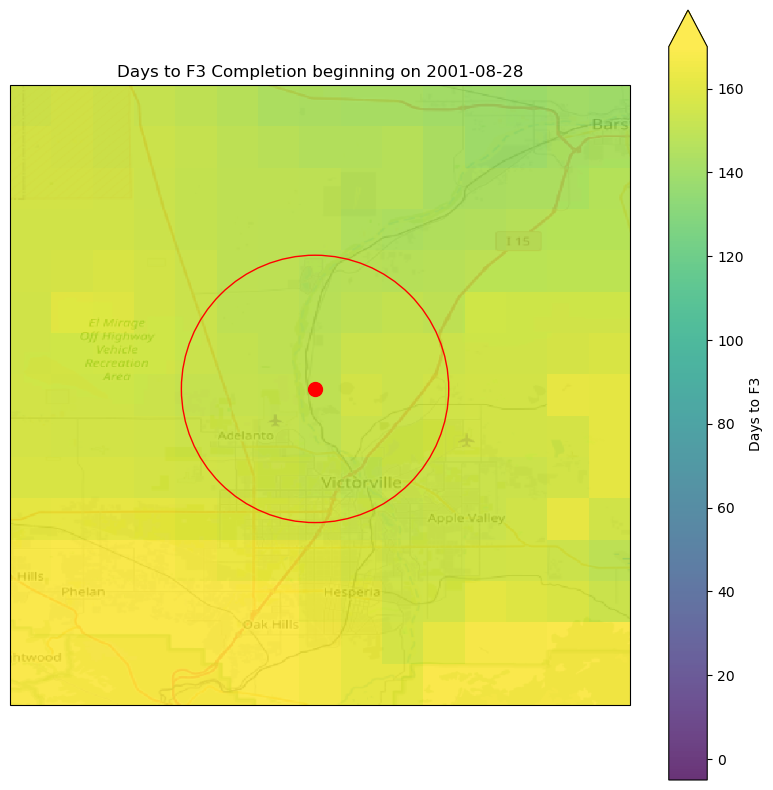

In [54]:
run_plot_DD([pd.to_datetime("2020-01-01")], [(34.63115, -117.338321)], "Mexfly")